In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as stat
import seaborn as sns
import keras
from sklearn.metrics import mean_squared_error

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

,tair
datetime,
2021-10-01,32.9
2021-10-02,31.0
2021-10-03,26.7
2021-10-04,27.7
2021-10-05,29.2
...,...
2023-11-04,29.3
2023-11-05,29.0
2023-11-06,28.0


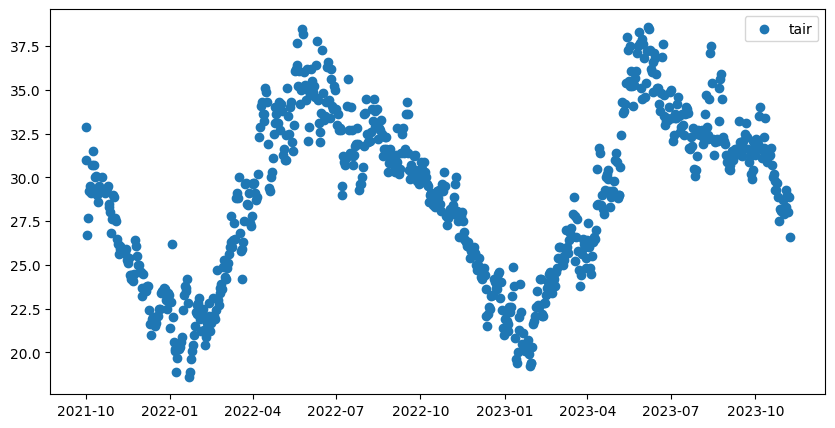

In [98]:
# read air temperature data and plot
t =  pd.read_excel('/content/tair.xlsx')
plt.figure(figsize=(10,5))
plt.scatter(t["datetime"],t["tair"])
plt.legend(["tair"])

# set time data as index
t[t.columns[0]]=pd.to_datetime(t[t.columns[0]]).dt.date
t[t.columns[0]] = pd.to_datetime(t[t.columns[0]])
t.set_index(t.columns[0],inplace=True)
display(t)

# prediction
In this Python script, we aim to predict air temperature 10 days ahead.
The data is first split into training and test sets, with the last 77 days used for testing. We compared the prediction accuracy using various models, including ARIMA, linear regression, support vector regression (SVR), random forest regressor, extra trees regressor, and a simple recurrent neural network (RNN). Among these, ARIMA demonstrated the best performance on the test set, so we used it for the final predictions.

In [ ]:
!pip install pmdarima
import pmdarima as pm

In [6]:
#Automatically discover the optimal order for an ARIMA model.
def optimal_order_ARIMA(dataframe,column):
  """
     Discovering the optimal order of ARIMA model and show it.

    Argument:
    dataframe -- a timeseries datafram.
    column -- str,column to be modeled.
  """
  model = pm.arima.auto_arima(dataframe[column], start_p=0, start_q=0,
                              max_order=6, test='adf', error_action='ignore',
                              suppress_warnings=True, stepwise=True, trace=True)
optimal_order_ARIMA(t,"tair")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.415, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2283.830, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.712, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2283.460, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2262.256, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2199.606, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2220.705, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2196.992, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2218.087, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2195.709, Time=0.88 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2207.866, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2197.668, Time=0.99 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2197.910, Time=3.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2196.455, Time=2.69 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept

True

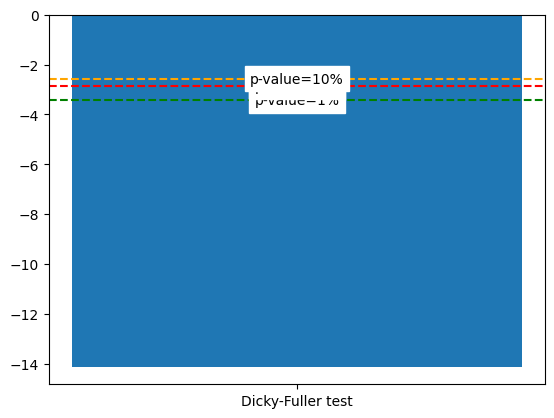

In [ ]:
# we check the stationarity of the data by applying first-order differencing (interval of 1) to remove trends
def differencing(dataframe,periods=1):
  """
    Calculates the difference of a DataFrame element compared with another element
    in the DataFrame (default is element in previous row).

    Argument:
    dataframe -- a timeseries dataframe.
    periods -- Periods to shift for calculating difference, accepts negative values.

    Returns:
    df_new -- new calculated dataframe.
  """
  d=dataframe.reset_index()
  df_new=d.diff()
  df_new=df_new.dropna()
  return df_new
df_new=differencing(t,periods=1)
check_stationarity(df_new,"tair")

In [7]:
def train_test_split(dataframe,test_percentage=10):
  """
    Split dataframe to train and test

    Argument:
    dataframe -- a dataframe.
    test_percentage -- Percentage of test data

    Returns:
    df_train -- dataframe include train data.
    df_test -- dataframe include test data.
  """

  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]
  return df_train , df_test

In [8]:
def plot_predicted_against_true_value(dataframe,column,df_predictions):
  """
    plot predicted value by ARIMA model against true value.

    Argument:
    dataframe -- a dataframe of type csv.
    column -- str,column to be modeled.
    df_predictions -- dataframe include True and predicted values.
  """
  plt.rcParams["figure.figsize"] =(12, 4)
  plt.plot(dataframe[column], label="True value")
  plt.plot(df_predictions["prediction"], color='red',label="prediction", marker='o',markersize=3)
  plt.legend()
  plt.show()

In [ ]:
def test_ARIMA_model(dataframe, column,exogenous_column=None,Trend='ct', order=(0, 0, 0), test_percentage=10):
  """
    test ARIMA model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a timeseries dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables
    order -- tuple, The (p,d,q) order of the model for the autoregressive,
            differences, and moving average components.
    Trend -- str{'c','t','ct'}, Parameter controlling the deterministic trend.
             Can be specified as a string where 'c' indicates a constant term,
             't' indicates a linear trend in time, and 'ct' includes both.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  df_train, df_test =train_test_split(dataframe,test_percentage)
  history = [x for x in df_train[column]]
  print(history)
  if exogenous_column != None:
   exogenous_history= [x for x in df_train[exogenous_column]]
   exogenous_test= [x for x in df_test[exogenous_column]]
  else:
    exogenous_history= None
    exogenous_test= None

  predictions = list()
  for t in range(len(df_test)):
    model = stat.tsa.arima.model.ARIMA(history, order=order,trend=Trend,exog=exogenous_history )
    model_fit = model.fit()
    output = model_fit.forecast(exog=exogenous_test)
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test[column][t]
    history.append(obs)
    if exogenous_column != None:
      oexog=df_test[exogenous_column][t]
      exogenous_history.append(oexog)
    print("\033[95m\033[1mDate=\033[0m",df_test.index[t])
    print('predicted= %f, expected= %f' % (yhat, obs))

  df_predictions=pd.DataFrame(predictions,index=df_test.index,columns=["prediction"])
  df_predictions["true_value"]=df_test[column]
  rmse = math.sqrt(mean_squared_error(df_test[column], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions
df_predictions=test_ARIMA_model(t, "tair",exogenous_column=None,Trend='t', order=(4,1,1), test_percentage=10)

number of train data is:
692
number of test data is:
77
[32.9, 31.0, 26.7, 27.7, 29.2, 29.5, 29.1, 30.7, 31.5, 30.7, 30.0, 30.1, 29.0, 28.6, 29.4, 29.5, 29.3, 29.3, 30.0, 29.2, 29.3, 29.1, 29.3, 29.4, 29.5, 28.5, 28.3, 28.0, 26.8, 27.6, 29.0, 28.9, 27.7, 27.5, 26.5, 26.2, 25.6, 25.9, 26.1, 25.8, 25.8, 25.9, 25.7, 25.7, 25.9, 25.3, 25.1, 25.4, 24.4, 24.2, 24.4, 24.2, 24.1, 24.5, 26.4, 26.1, 25.5, 25.0, 25.0, 24.6, 24.6, 23.7, 23.2, 24.5, 23.7, 23.5, 23.5, 23.8, 23.8, 22.4, 21.6, 21.0, 21.9, 22.0, 21.9, 21.7, 21.5, 21.7, 22.1, 22.1, 22.5, 22.5, 23.4, 23.5, 23.5, 23.5, 23.7, 23.6, 23.0, 22.5, 23.4, 23.3, 21.4, 22.9, 26.2, 22.0, 20.6, 20.1, 20.2, 18.9, 19.7, 20.3, 20.2, 20.3, 20.6, 20.9, 22.4, 23.3, 23.8, 23.5, 23.7, 24.2, 22.8, 18.6, 18.9, 19.6, 20.1, 20.4, 21.0, 21.5, 22.3, 22.2, 22.7, 22.8, 23.1, 21.9, 21.2, 22.1, 22.5, 21.3, 20.4, 20.9, 21.7, 21.7, 22.1, 22.8, 21.2, 21.7, 22.1, 23.1, 22.1, 21.9, 22.4, 24.7, 23.0, 22.7, 23.4, 23.7, 23.9, 23.6, 24.9, 25.3, 24.3, 24.2, 24.8, 25.1, 25.6, 2

<ipython-input-179-634353380d35>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = df_test[column][t]


Date= 2023-08-24
predicted= 34.906137, expected= 35.600000
Date= 2023-08-25
predicted= 34.920670, expected= 35.900000
Date= 2023-08-26
predicted= 35.396557, expected= 34.500000
Date= 2023-08-27
predicted= 33.907761, expected= 32.300000
Date= 2023-08-28
predicted= 32.303592, expected= 32.100000
Date= 2023-08-29
predicted= 32.725874, expected= 31.900000
Date= 2023-08-30
predicted= 32.257727, expected= 31.300000
Date= 2023-08-31
predicted= 31.741887, expected= 30.900000
Date= 2023-09-01
predicted= 31.414774, expected= 31.100000
Date= 2023-09-02
predicted= 31.572504, expected= 30.500000
Date= 2023-09-03
predicted= 30.737597, expected= 30.400000
Date= 2023-09-04
predicted= 30.842012, expected= 30.700000
Date= 2023-09-05
predicted= 30.984042, expected= 31.000000
Date= 2023-09-06
predicted= 31.137794, expected= 31.500000
Date= 2023-09-07
predicted= 31.555214, expected= 31.000000
Date= 2023-09-08
predicted= 30.851607, expected= 31.300000
Date= 2023-09-09
predicted= 31.429720, expected= 31.6000

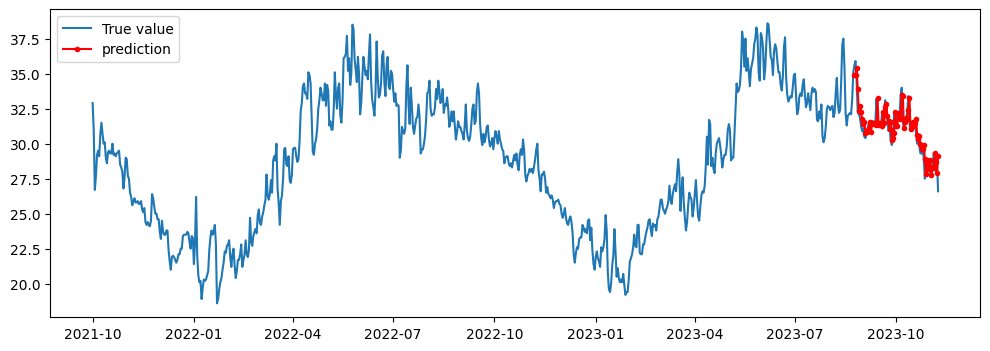

In [ ]:
plot_predicted_against_true_value(t,"tair",df_predictions)

In [23]:
pip install skforecast

number of train data is:
692
number of test data is:
77
Test RMSE(root mean squre error): 1.553605510417839


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


,prediction,true_value
datetime,,
2023-08-24,34.942650,35.6
2023-08-25,34.789228,35.9
2023-08-26,34.639637,34.5
2023-08-27,34.493780,32.3
2023-08-28,34.351564,32.1
...,...,...
2023-11-04,29.792662,29.3
2023-11-05,29.767812,29.0
2023-11-06,29.743582,28.0


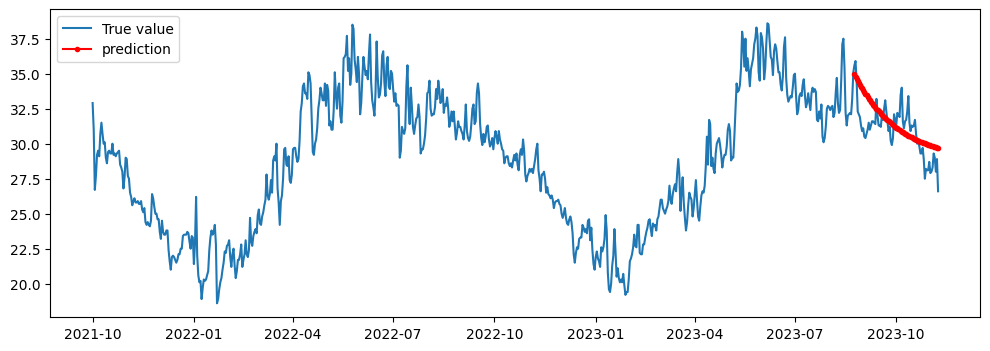

In [33]:
def test_LinearRegression_model(dataframe, column,exogenous_column=None,lags_for_prediction=5, test_percentage=10):
  """
    test RandomForestRegressor model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a timeseries dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables.
    lags_for_prediction --  Lags used as predictors.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]

  y_train=(df_train[column]-min(dataframe[column]))/max(dataframe[column])
  y_test=(df_test[column]-min(dataframe[column]))/max(dataframe[column])


  if exogenous_column != None:
    exogenous_history=(df_train[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])
    exogenous_test=(df_test[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])

  else:
    exogenous_history= None
    exogenous_test= None

  forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = lags_for_prediction
              )
  forecaster.fit(y=y_train,exog=exogenous_history)
  predictions = forecaster.predict(steps=test_num,exog=exogenous_test)
  df_predictions=pd.DataFrame(predictions.values*max(dataframe[column])+min(dataframe[column]),index=y_test.index,columns=["prediction"])
  df_predictions["true_value"]=y_test*max(dataframe[column])+min(dataframe[column])
  rmse = math.sqrt(mean_squared_error(df_predictions["true_value"], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions

df_predictions=test_LinearRegression_model(t, "tair",exogenous_column=None,lags_for_prediction=1, test_percentage=10)
display(df_predictions)
plot_predicted_against_true_value(t,"tair",df_predictions)

number of train data is:
692
number of test data is:
77
Test RMSE(root mean squre error): 3.3292161586295674


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


,prediction,true_value
datetime,,
2023-08-24,34.440000,35.6
2023-08-25,34.233333,35.9
2023-08-26,33.400000,34.5
2023-08-27,33.760000,32.3
2023-08-28,34.240000,32.1
...,...,...
2023-11-04,33.760000,29.3
2023-11-05,34.240000,29.0
2023-11-06,33.400000,28.0


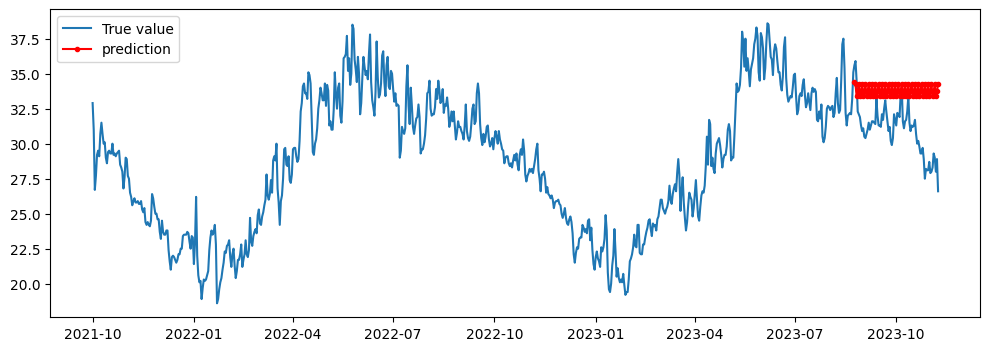

In [41]:
def test_ExtraTreeRegressor_model(dataframe, column,exogenous_column=None,lags_for_prediction=5, test_percentage=10):
  """
    test RandomForestRegressor model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables.
    lags_for_prediction --  Lags used as predictors.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]

  y_train=(df_train[column]-min(dataframe[column]))/max(dataframe[column])
  y_test=(df_test[column]-min(dataframe[column]))/max(dataframe[column])


  if exogenous_column != None:
    exogenous_history=(df_train[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])
    exogenous_test=(df_test[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])

  else:
    exogenous_history= None
    exogenous_test= None

  forecaster = ForecasterAutoreg(
                regressor = ExtraTreeRegressor(random_state=100),
                lags      = lags_for_prediction
              )
  forecaster.fit(y=y_train,exog=exogenous_history)
  predictions = forecaster.predict(steps=test_num,exog=exogenous_test)
  df_predictions=pd.DataFrame(predictions.values*max(dataframe[column])+min(dataframe[column]),index=y_test.index,columns=["prediction"])
  df_predictions["true_value"]=y_test*max(dataframe[column])+min(dataframe[column])
  rmse = math.sqrt(mean_squared_error(df_predictions["true_value"], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions

df_predictions=test_ExtraTreeRegressor_model(t, "tair",exogenous_column=None,lags_for_prediction=1, test_percentage=10)
display(df_predictions)
plot_predicted_against_true_value(t,"tair",df_predictions)

number of train data is:
692
number of test data is:
77


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


Test RMSE(root mean squre error): 4.277189793683023


,prediction,true_value
datetime,,
2023-08-24,34.430996,35.6
2023-08-25,34.190566,35.9
2023-08-26,34.540996,34.5
2023-08-27,35.339781,32.3
2023-08-28,35.292883,32.1
...,...,...
2023-11-04,34.430996,29.3
2023-11-05,34.190566,29.0
2023-11-06,34.540996,28.0


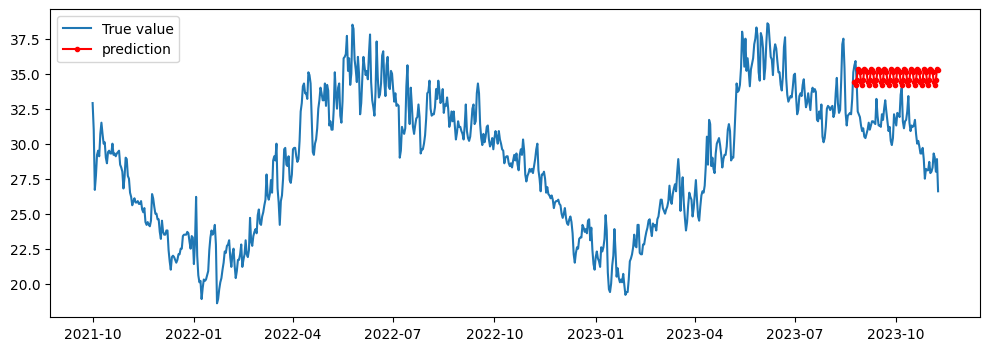

In [46]:
def test_RandomForestRegressor_model(dataframe, column,exogenous_column=None,lags_for_prediction=5, test_percentage=10):
  """
    test RandomForestRegressor model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables.
    lags_for_prediction --  Lags used as predictors.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]

  y_train=(df_train[column]-min(dataframe[column]))/max(dataframe[column])
  y_test=(df_test[column]-min(dataframe[column]))/max(dataframe[column])


  if exogenous_column != None:
    exogenous_history=(df_train[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])
    exogenous_test=(df_test[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])

  else:
    exogenous_history= None
    exogenous_test= None

  forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = lags_for_prediction
              )
  forecaster.fit(y=y_train,exog=exogenous_history)
  predictions = forecaster.predict(steps=test_num,exog=exogenous_test)
  df_predictions=pd.DataFrame(predictions.values*max(dataframe[column])+min(dataframe[column]),index=y_test.index,columns=["prediction"])
  df_predictions["true_value"]=y_test*max(dataframe[column])+min(dataframe[column])
  rmse = math.sqrt(mean_squared_error(df_predictions["true_value"], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions

df_predictions=test_RandomForestRegressor_model(t, "tair",exogenous_column=None,lags_for_prediction=1, test_percentage=10)
display(df_predictions)
plot_predicted_against_true_value(t,"tair",df_predictions)

number of train data is:
692
number of test data is:
77
number of timestep to predict next time step is considered: 38
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0285
Epoch 2/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0133
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0128
Epoch 4/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0110
Epoch 5/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093
Epoch 6/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093
Epoch 7/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0081
Epoch 8/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0076
Epoch 9/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0067
Epoch 10/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071
Epoch 11/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0057
Epoch 12/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0054
Epoch 13/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0051
Epoch 14/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0051
Epoch 15/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0046


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Test RMSE(root mean squre error):1.6751471158332731


,prediction,true_value
2023-10-01,31.734287,31.3
2023-10-02,31.584553,32.2
2023-10-03,31.834938,32.1
2023-10-04,31.941702,31.9
2023-10-05,31.677822,33.5
2023-10-06,32.102760,34.0
2023-10-07,32.481873,31.6
2023-10-08,31.758381,31.1
2023-10-09,31.590435,31.6
2023-10-10,32.215397,31.7


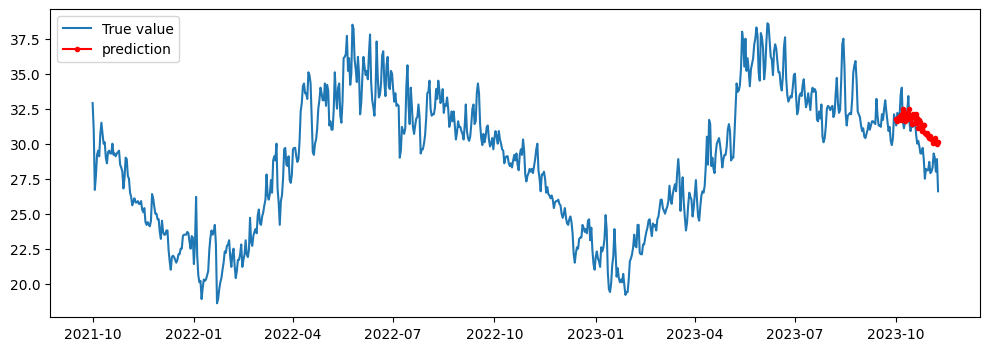

In [37]:
def test_simpleRNN_model(dataframe, column, num_RNN_unit=2, test_percentage=10):
  """
    test simpleRNN model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    num_RNN_unit -- number of units in simpleRNN layer.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """


  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]

  df_train=(df_train[column]-min(dataframe[column]))/max(dataframe[column])
  df_test=(df_test[column]-min(dataframe[column]))/max(dataframe[column])

  y_p = [x for x in df_train]
  y_t = [x for x in df_test]


  X_train = []
  y_train = []
  split_num=round(0.5*len(df_test))
  print(f"number of timestep to predict next time step is considered: {split_num}")
  for i in range(split_num, len(df_train)):
    X_train.append(y_p[i-split_num:i])
    y_train.append(y_p[i])

  X_train=np.array(X_train)
  y_train=np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
  y_train = np.reshape(y_train, (y_train.shape[0],1))


  X_test = []
  y_test = []
  index_test=[]
  for i in range(split_num, len(df_test)):
    X_test.append(y_t[i-split_num:i])
    y_test.append(y_t[i])
    index_test.append(df_test.index[i])

  X_test=np.array(X_test)
  y_test=np.array(y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
  y_test = np.reshape(y_test, (y_test.shape[0],1))


  simple_RNN_model = Sequential()
  simple_RNN_model.add(SimpleRNN(units = num_RNN_unit, input_shape = (X_train.shape[1],1)))
  simple_RNN_model.add(Dense(units = 1,activation='sigmoid'))

  simple_RNN_model.compile(optimizer = SGD(learning_rate=0.01),loss = "mean_squared_error")
  simple_RNN_model.fit(X_train, y_train, epochs = 20,batch_size=2)
  y_RNN = simple_RNN_model.predict(X_test)
  y_RNN=y_RNN*max(dataframe[column])+min(dataframe[column])
  df_predictions=pd.DataFrame(y_RNN,index=index_test,columns=["prediction"])
  df_predictions["true_value"]=y_test*max(dataframe[column])+min(dataframe[column])
  rmse = math.sqrt(mean_squared_error(df_predictions["true_value"], df_predictions["prediction"]))
  print(f"Test RMSE(root mean squre error):{rmse}")
  return df_predictions
df_predictions=test_simpleRNN_model(t, "tair", num_RNN_unit=2, test_percentage=10)
display(df_predictions)
plot_predicted_against_true_value(t,"tair",df_predictions)

number of train data is:
692
number of test data is:
77
Test RMSE(root mean squre error): 7.1508184250915265


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


,prediction,true_value
datetime,,
2023-08-24,34.713340,35.6
2023-08-25,34.427794,35.9
2023-08-26,34.188347,34.5
2023-08-27,33.971165,32.3
2023-08-28,33.762822,32.1
...,...,...
2023-11-04,22.085215,29.3
2023-11-05,22.085215,29.0
2023-11-06,22.085215,28.0


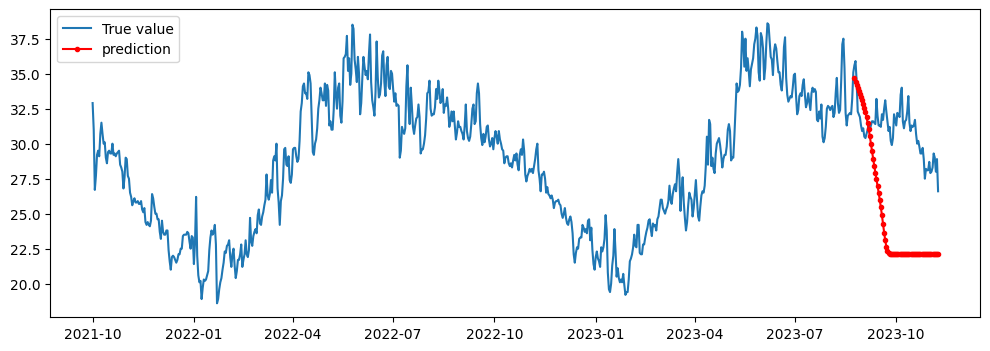

In [48]:
def test_SVR_model(dataframe, column,exogenous_column=None,lags_for_prediction=5, test_percentage=10):
  """
    test RandomForestRegressor model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables.
    lags_for_prediction --  Lags used as predictors.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  test_num=math.ceil(len(dataframe)*test_percentage/100)
  print('\033[95m'+'\033[1m'f"number of train data is:\n\033[0m{len(dataframe)-test_num}")
  print('\033[95m'+'\033[1m'f"number of test data is:\n\033[0m{test_num}")
  df_train=dataframe.iloc[0:len(dataframe)-test_num]
  df_test=dataframe.iloc[len(dataframe)-test_num:]

  y_train=(df_train[column]-min(dataframe[column]))/max(dataframe[column])
  y_test=(df_test[column]-min(dataframe[column]))/max(dataframe[column])


  if exogenous_column != None:
    exogenous_history=(df_train[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])
    exogenous_test=(df_test[exogenous_column]-min(dataframe[exogenous_column]))/max(dataframe[exogenous_column])

  else:
    exogenous_history= None
    exogenous_test= None

  forecaster = ForecasterAutoreg(
                regressor = svm.SVR(),
                lags      = lags_for_prediction
              )
  forecaster.fit(y=y_train,exog=exogenous_history)
  predictions = forecaster.predict(steps=test_num,exog=exogenous_test)
  df_predictions=pd.DataFrame(predictions.values*max(dataframe[column])+min(dataframe[column]),index=y_test.index,columns=["prediction"])
  df_predictions["true_value"]=y_test*max(dataframe[column])+min(dataframe[column])
  rmse = math.sqrt(mean_squared_error(df_predictions["true_value"], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions

df_predictions = test_SVR_model(t, "tair",exogenous_column=None,lags_for_prediction=1, test_percentage=10)
display(df_predictions)
plot_predicted_against_true_value(t,"tair",df_predictions)

In [131]:
# as the ARIMA shows best performance on test data, this model is used for prediction
def ARIMA_forcast(dataframe, column,exogenous_column=None, exogenous_forcast=None,Trend='ct', order=(0, 0, 0),forecast_steps=1):
  """
    forcast future steps by ARIMA model.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables
    exogenous_forcast -- dataframe, inclute exogenous data with the columns same as exogenous_column.
    if exogenous_column is not None it sould be provided.
    order -- tuple, The (p,d,q) order of the model for the autoregressive,
            differences, and moving average components.
    Trend -- str{'c','t','ct'}, Parameter controlling the deterministic trend.
             Can be specified as a string where 'c' indicates a constant term,
             't' indicates a linear trend in time, and 'ct' includes both.
    forecast_steps -- number of steps to be forcasted.

    Returns:
    df_forcast -- dataframe include forcasted values.
  """

  history = [x for x in dataframe[column]]
  if exogenous_column != None:
   exogenous_history= [x for x in dataframe[exogenous_column]]
  else:
    exogenous_history= None



  predictions = list()
  for t in range(forecast_steps):
    model = stat.tsa.arima.model.ARIMA(history, order=order,trend=Trend,exog=exogenous_history )
    model_fit = model.fit()
    output = model_fit.forecast(exog=exogenous_forcast)
    yhat = output[0]
    predictions.append(yhat)
    obs = predictions[t]
    history.append(obs)
    if exogenous_column != None:
      oexog=exogenous_forcast[exogenous_column][t]
      exogenous_history.append(oexog)

  df_forcast=pd.DataFrame(predictions,
                              index=pd.date_range(start=dataframe.index[-1], periods=forecast_steps+1, freq=pd.to_datetime(dataframe.index).freq)[1:]
                              ,columns=["prediction"])
  display(df_forcast)

  return df_forcast

df_forcast = ARIMA_forcast(t,"tair",Trend='t',order=(4,1,1),forecast_steps=10)

,prediction
2023-11-09,26.263010
2023-11-10,27.034590
2023-11-11,27.373266
2023-11-12,27.479024
2023-11-13,27.556334
2023-11-14,27.556884
2023-11-15,27.514154
2023-11-16,27.481225
2023-11-17,27.463867
2023-11-18,27.455067


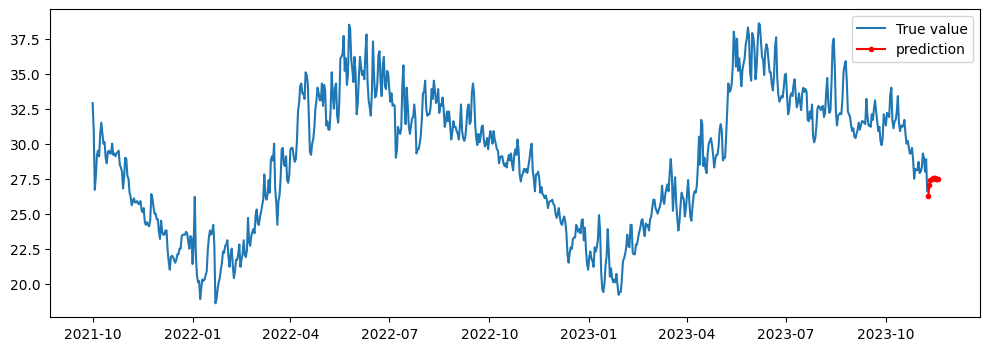

In [132]:
plot_predicted_against_true_value(t,"tair",df_forcast)

# Monthly prediction
First, resample the data to a monthly frequency. Then, use the ARIMA model to predict the next three months air temperature.

In [100]:
def resampling(dataframe,method="mean",rule='M'):
  """
    Resampling dataframe based on specified rule.

    Argument:
    dataframe -- a dataframe of type csv.
    method -- method to spesified the value of each group base on the original value
              include: "mean" : setting mean of values for each group.
                       "sum" : setting sum of values for each group.
                       "asfreq" : Convert time series to specified frequency.
                       "ffill" : for upsampling forward filling Nan values.
                       "bfill" :  for upsampling backward filling Nan values.
    rule -- The offset string or object representing target conversion.


    Returns:
    df_new --   Resampled dataframe.
  """
  d=dataframe.resample(rule)
  if method == "mean":
    df_new=d.mean()
  elif method == "sum":
    df_new=d.sum()
  elif method == "asfreq":
    df_new=d.asfreq()
  elif method == "ffill":
    df_new=d.ffill()
  elif method == "bfill":
    df_new=d.bfill()
  return df_new

# resampling to monthly frequency
tair_monthly = resampling(t,method="mean",rule='M')
display(tair_monthly)

<ipython-input-100-563f9ca9a0f0>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  d=dataframe.resample(rule)


,tair
datetime,
2021-10-31,29.296774
2021-11-30,25.600000
2021-12-31,22.838710
2022-01-31,21.461290
2022-02-28,22.460714
2022-03-31,26.987097
2022-04-30,31.993333
2022-05-31,34.335484
2022-06-30,34.666667


In [122]:
def test_ARIMA_model(dataframe, column,exogenous_column=None,Trend='ct', order=(0, 0, 0), test_percentage=10):
  """
    test ARIMA model on dataframe[column] and calculate RMSE.

    Argument:
    dataframe -- a timeseries dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables
    order -- tuple, The (p,d,q) order of the model for the autoregressive,
            differences, and moving average components.
    Trend -- str{'c','t','ct'}, Parameter controlling the deterministic trend.
             Can be specified as a string where 'c' indicates a constant term,
             't' indicates a linear trend in time, and 'ct' includes both.
    test_percentage -- Percentage of test data.

    Returns:
    df_predictions -- dataframe include True and predicted values.
  """

  df_train, df_test =train_test_split(dataframe,test_percentage)
  history = [x for x in df_train[column]]
  print(history)
  if exogenous_column != None:
   exogenous_history= [x for x in df_train[exogenous_column]]
   exogenous_test= [x for x in df_test[exogenous_column]]
  else:
    exogenous_history= None
    exogenous_test= None

  predictions = list()
  for t in range(len(df_test)):
    model = stat.tsa.arima.model.ARIMA(history, order=order,trend=Trend,exog=exogenous_history )
    model_fit = model.fit()
    output = model_fit.forecast(exog=exogenous_test)
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test[column][t]
    history.append(obs)
    if exogenous_column != None:
      oexog=df_test[exogenous_column][t]
      exogenous_history.append(oexog)
    print("\033[95m\033[1mDate=\033[0m",df_test.index[t])
    print('predicted= %f, expected= %f' % (yhat, obs))

  df_predictions=pd.DataFrame(predictions,index=df_test.index,columns=["prediction"])
  df_predictions["true_value"]=df_test[column]
  rmse = math.sqrt(mean_squared_error(df_test[column], df_predictions["prediction"]))
  print('\033[95m'+'\033[1m'f"Test RMSE(root mean squre error): \033[0m{rmse}")
  return df_predictions
df_predictions=test_ARIMA_model(tair_monthly, "tair",exogenous_column=None,Trend='t', order=(2,1,1), test_percentage=10)

number of train data is:
23
number of test data is:
3
[29.296774193548387, 25.6, 22.838709677419356, 21.461290322580645, 22.460714285714285, 26.98709677419355, 31.993333333333332, 34.33548387096774, 34.666666666666664, 31.74516129032258, 32.49354838709677, 31.16, 29.19677419354839, 27.173333333333336, 23.606451612903225, 21.25483870967742, 23.425, 26.03548387096774, 28.313333333333333, 34.47096774193548, 35.56666666666667, 32.79354838709678, 33.20645161290323]
Date= 2023-09-30 00:00:00
predicted= 32.698216, expected= 31.410000


<ipython-input-122-12473df513c5>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = df_test[column][t]


Date= 2023-10-31 00:00:00
predicted= 29.768506, expected= 30.745161
Date= 2023-11-30 00:00:00
predicted= 30.289127, expected= 28.250000
Test RMSE(root mean squre error): 1.5023754879717364


In [128]:
# as the ARIMA shows best performance on test data, this model is used for prediction
def ARIMA_forcast(dataframe, column,exogenous_column=None, exogenous_forcast=None,Trend='ct', order=(0, 0, 0),forecast_steps=1):
  """
    forcast future steps by ARIMA model.

    Argument:
    dataframe -- a dataframe.
    column -- str,column to be modeled.
    exogenous_column -- columns include exogenous variables
    exogenous_forcast -- dataframe, inclute exogenous data with the columns same as exogenous_column.
    if exogenous_column is not None it sould be provided.
    order -- tuple, The (p,d,q) order of the model for the autoregressive,
            differences, and moving average components.
    Trend -- str{'c','t','ct'}, Parameter controlling the deterministic trend.
             Can be specified as a string where 'c' indicates a constant term,
             't' indicates a linear trend in time, and 'ct' includes both.
    forecast_steps -- number of steps to be forcasted.

    Returns:
    df_forcast -- dataframe include forcasted values.
  """

  history = [x for x in dataframe[column]]
  if exogenous_column != None:
   exogenous_history= [x for x in dataframe[exogenous_column]]
  else:
    exogenous_history= None



  predictions = list()
  for t in range(forecast_steps):
    model = stat.tsa.arima.model.ARIMA(history, order=order,trend=Trend,exog=exogenous_history )
    model_fit = model.fit()
    output = model_fit.forecast(exog=exogenous_forcast)
    yhat = output[0]
    predictions.append(yhat)
    obs = predictions[t]
    history.append(obs)
    if exogenous_column != None:
      oexog=exogenous_forcast[exogenous_column][t]
      exogenous_history.append(oexog)

  df_forcast=pd.DataFrame(predictions,
                              index=pd.date_range(start=dataframe.index[-1], periods=forecast_steps+1, freq=pd.to_datetime(dataframe.index).freq)[1:]
                              ,columns=["prediction"])
  display(df_forcast)

  return df_forcast

df_forcast = ARIMA_forcast(tair_monthly,"tair",Trend='t',order=(2,1,1),forecast_steps=3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,prediction
2023-12-31,27.038778
2024-01-31,27.112763
2024-02-29,28.071368


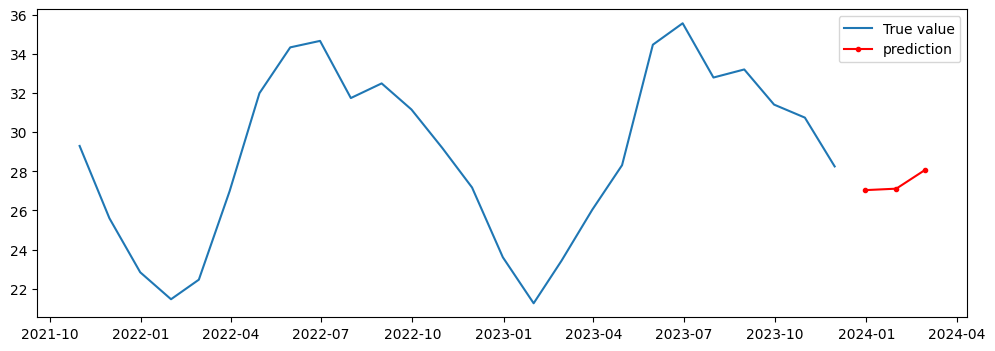

In [129]:
plot_predicted_against_true_value(tair_monthly,"tair",df_forcast)